In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython.display import display, clear_output
from scipy.optimize import minimize, least_squares
from scipy.integrate import odeint
import scipy
import time
import matplotlib
from scipy.interpolate import RectBivariateSpline
import pandas as pd
from numba import njit
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

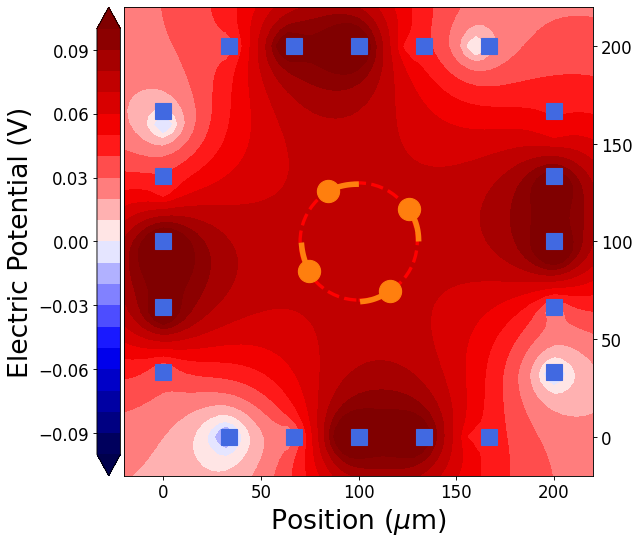

599 8
done


In [7]:
ns =600 #number of time steps
t = np.linspace(0,300,ns+1) #s
delta_t = t[1] - t[0]
Lxy = 0.0002#*1E6 #m

Brown = 0

#Trajectory
v0 = 1E-6#*1E6 #loiter velocity, m/s
rd = 3E-5#*1E6 #desired loiter distance, m
xt = Lxy/2
yt = Lxy/2 #coordinates of center of circle
print("Delta t", delta_t)
print("Period", 2*np.pi*rd/v0)

#pos = np.array([[xt+rd,yt]]) #particle initial positions
pos = np.array([[xt+rd,yt],[xt,yt+rd],[xt-rd,yt],[xt,yt-rd]])
#pos = np.array([[xt,yt]])
nparticles = len(pos)

epsilon0 = 78.4*8.8542E-12#/(1E6)**2 #C^2/Nm^2 #This uses the dielectric constant of water. I should change the symbol.
mobility = 2E-8#*(1E6)**2 #units of Coulomb/Newton * m/s or m^2/V s 

W1 = 20
qmax = v0/np.abs(mobility)*2*np.pi*epsilon0*Lxy


ncharges = 20 #must be multiple of 4
chargepos = np.zeros((ncharges,2))
#spacing = Lxy/2
spacing = Lxy/(ncharges/4 + 1)
count0 = 0
count1 = 0
count2 = 0
count3 = 0
for i in range(ncharges):
    if i%4 == 0: #left side
        chargepos[i,0]+= 0
        count0 += spacing
        chargepos[i,1]+= count0
    if i%4 == 1: #right side
        chargepos[i,0] += Lxy
        count1 += spacing
        chargepos[i,1]+= count1
    if i%4 == 2: #bottom
        chargepos[i,1]+= 0
        count2 += spacing
        chargepos[i,0]+=count2
        
    if i%4 == 3: #top
        chargepos[i,1]+= Lxy
        count3 += spacing
        chargepos[i,0]+= count3
# chargepos[0] = np.array([0,Lxy/2]) #West
# chargepos[1] = np.array([Lxy/2,Lxy]) #North

#used to find characteristic Brownian scales
T = 298 #K
kb = 1.38064852E-23#*(1E6)**2 #boltzmann's constant kg m^2/s^2K
viscosity = 8.9E-4#/1E6 #viscosity of water kg/ms
radius = 1E-6#*1E6 #m, radius of particle
gamma = viscosity*6*np.pi*radius #Pa*s
Dp = kb*T/gamma

A = np.zeros((nparticles,ncharges,2))

@njit
def targetpos(t):
    x = np.zeros(nparticles)
    y = np.zeros(nparticles)
    x[0] = xt+rd*np.cos(v0*t/rd)
    y[0] = yt+rd*np.sin(v0*t/rd)
    x[1] = xt+rd*np.cos(v0*t/rd+np.pi/2)
    y[1] = yt+rd*np.sin(v0*t/rd+np.pi/2)
    x[2] = xt+rd*np.cos(v0*t/rd+np.pi)
    y[2] = yt+rd*np.sin(v0*t/rd+np.pi)
    x[3] = xt+rd*np.cos(v0*t/rd+3/2*np.pi)
    y[3] = yt+rd*np.sin(v0*t/rd+3/2*np.pi)
    return np.vstack((x,y))

@njit
def targetfeedback(xs,t,xyought):
    k = 2.0
    x = xs[0]
    y = xs[1]
    xought = xyought[0]
    yought = xyought[1]
    dx = np.zeros(nparticles)
    dy = np.zeros(nparticles)
    dx[0] = -v0*np.sin(v0*t/rd)-k*(x[0]-xought[0])
    dy[0] = v0*np.cos(v0*t/rd) -k*(y[0]-yought[0])
    dx[1] = -v0*np.sin(v0*t/rd+np.pi/2)-k*(x[1]-xought[1])
    dy[1] = v0*np.cos(v0*t/rd+np.pi/2) -k*(y[1]-yought[1])
    dx[2] = -v0*np.sin(v0*t/rd+np.pi)-k*(x[2]-xought[2])
    dy[2] = v0*np.cos(v0*t/rd+np.pi) -k*(y[2]-yought[2])
    dx[3] = -v0*np.sin(v0*t/rd+3/2*np.pi)-k*(x[3]-xought[3])
    dy[3] = v0*np.cos(v0*t/rd+3/2*np.pi) -k*(y[3]-yought[3])
    return np.vstack((dx,dy))

ansopen = np.zeros((ns,2))
ansopen[0] = pos[0]
ansfeedback = ansopen.copy()*0
#ansfeedback[0] doesn't matter because it doesn't get used. 


chargeguess = np.zeros(ncharges)
qs = np.zeros(ncharges)  #store calculated q's

x = np.zeros((ns,nparticles))
y = np.zeros((ns,nparticles))
x[0,:] = pos[:,0]
y[0,:] = pos[:,1]

@njit
def findA(x,y,nparticles): #this is the model, except for the gammas. 
    A = np.zeros((nparticles,ncharges,2))
    for i in range(nparticles):
        for j in range(ncharges):
            xij = x[i] - chargepos[j,0] #x distance from j'th electrode
            yij = y[i] - chargepos[j,1] #y distance from j'th electrode
#             A[i,j] = np.array([xij/(xij**2+yij**2)**1.5, yij/(xij**2+yij**2)**1.5]) #this comes from Coulomb's law. E = 1/4pi eps0 |q|/r^2.
            #if you use that equation, find the x component of E, and substitute in for x and y, you get Ex = x q /(x^2+y^2)^3/2.
            A[i,j] = np.array([xij/(xij**2+yij**2),yij/(xij**2+yij**2)])
    return A*mobility*1/(2*np.pi*epsilon0) #2D uses 2, 3d uses 4

@njit
def model(xy,t,gammas,nparticles):
    x = xy[:nparticles]
    y = xy[nparticles:]
    A = findA(x,y,nparticles)
    Ax = A[:,:,0]
    Ay = A[:,:,1]
    for i in range(ncharges):
        vx = np.dot(Ax,gammas)
        vy = np.dot(Ay,gammas)
    return np.append(vx,vy)

@njit
def mintarget2(gamma,x,y,k,t):  
    modelans = model(np.hstack((x,y)),0,gamma,nparticles)
    modelxpos = x + modelans[:nparticles]*delta_t
    modelypos = y + modelans[nparticles:]*delta_t
    temp = np.vstack((modelxpos,modelypos))
    temp2 = targetpos(t[k])
    vreq = targetfeedback(temp,t[k],temp2) 
    xerr = vreq[0] - modelans[:nparticles]
    yerr = vreq[1] - modelans[nparticles:]
    temp3 = np.append(xerr,yerr)
    return np.append(temp3/v0*W1,gamma/qmax)

boundaryscale = 3
Lxysim = boundaryscale*Lxy
nxy     = int(50*boundaryscale)+1         # number of grid points in x and y directions
deltaxy  = Lxysim/(nxy-1)            # grid spacing in x and y directions
    
grid = np.zeros((nxy,nxy))       # solution array
oldgrid = grid.copy()
S = np.zeros((nxy,nxy))        # source term array

interval = (boundaryscale-1)/2
xs = np.linspace(-interval*Lxy,(1+interval)*Lxy,nxy)
ys = np.linspace(-interval*Lxy,(1+interval)*Lxy,nxy)
Y,X = np.meshgrid(xs,ys) #I don't know why putting them backwards fixes it but it does


loindex = int((nxy-1)/2-(nxy-1)/(2*boundaryscale))
hiindex = int((nxy-1)/2+(nxy-1)/(2*boundaryscale))

zoom = loindex
iind = np.arange(1,nxy-1)
jind = np.arange(1,nxy-1)
spacing = int((nxy-1)/(boundaryscale*(ncharges/4+1)))
spacingmod = int((nxy-1)/(boundaryscale*2))
rprobe = deltaxy
dedge = (boundaryscale-1)*Lxy/2

dij = np.zeros((ncharges,ncharges))
for n in range(ncharges):
    for m in range(ncharges):
        dij[m,n] = np.linalg.norm(chargepos[m]-chargepos[n])

@njit
def BCs(u,grid):
    phi = -u/(2*np.pi*epsilon0)*(np.log(rprobe)-np.log(dedge))
    count0,count1,count2,count3 = (0,0,0,0)
    for n in range(ncharges):
        for m in range(ncharges):
            if m != n: 
                phi[n] += -u[m]/(2*np.pi*epsilon0)*(np.log(dij[m,n])-np.log(dedge))
        if n%4 == 0: #left side   
            count0 += spacing
            grid[loindex,loindex+count0] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex, loindex+count0+1] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex, loindex+count0-1] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex+1, loindex+count0] = phi[n]#*(np.log(rprobe)-np.log(dedge+rprobe))
            grid[loindex-1, loindex+count0] = phi[n]#*(np.log(rprobe)-np.log(dedge-rprobe))
        if n%4 == 1: #right side
            count1 += spacing
            grid[hiindex,loindex+count1]=phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[hiindex, loindex+count1+1] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[hiindex, loindex+count1-1] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[hiindex+1, loindex+count1] = phi[n]#*(np.log(rprobe)-np.log(dedge-rprobe))
            grid[hiindex-1, loindex+count1] = phi[n]#*(np.log(rprobe)-np.log(dedge+rprobe))
        if n%4 == 2: #bottom
            count2 += spacing
            grid[loindex+count2,loindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex+count2, loindex+1] = phi[n]#*(np.log(rprobe)-np.log(dedge+rprobe))
            grid[loindex+count2, loindex-1] = phi[n]#*(np.log(rprobe)-np.log(dedge-rprobe))
            grid[loindex+count2+1, loindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex+count2-1, loindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
        if n%4 == 3: #top
            count3 += spacing
            grid[loindex+count3,hiindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex+count3, hiindex+1] = phi[n]#*(np.log(rprobe)-np.log(dedge-rprobe))
            grid[loindex+count3, hiindex-1] = phi[n]#*(np.log(rprobe)-np.log(dedge+rprobe))
            grid[loindex+count3+1, hiindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
            grid[loindex+count3-1, hiindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
    return

# def BCs(phi,grid):
#     count0,count1,count2,count3 = (0,0,0,0)
#     for n in range(ncharges):
#         if n%4 == 0: #left side   
#             count0 += spacingmod
#             grid[loindex,loindex+count0] = phi[n]#*(np.log(rprobe)-np.log(dedge))
#             grid[loindex, loindex+count0+1] = phi[n]#*(np.log(rprobe)-np.log(dedge))
#             grid[loindex, loindex+count0-1] = phi[n]#*(np.log(rprobe)-np.log(dedge))
#             grid[loindex+1, loindex+count0] = phi[n]#*(np.log(rprobe)-np.log(dedge+rprobe))
#             grid[loindex-1, loindex+count0] = phi[n]#*(np.log(rprobe)-np.log(dedge-rprobe))
#         if n%4 == 1: #bottom
#             count1 += spacingmod
#             grid[loindex+count1,hiindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
#             grid[loindex+count1, hiindex+1] = phi[n]#*(np.log(rprobe)-np.log(dedge+rprobe))
#             grid[loindex+count1, hiindex-1] = phi[n]#*(np.log(rprobe)-np.log(dedge-rprobe))
#             grid[loindex+count1+1, hiindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
#             grid[loindex+count1-1, hiindex] = phi[n]#*(np.log(rprobe)-np.log(dedge))
#     return

S = grid.copy()*0

@njit
def relax(grid,u):
    while True:
        oldgrid = grid.copy()
        grid[1:-2,1:-2] = 1/4*(grid[0:-3,1:-2]+grid[2:-1,1:-2]+grid[1:-2,0:-3]+grid[1:-2,2:-1]) #+ S[1:-2,1:-2]/epsilon0/4
        BCs(u,grid) #probe boundary conditions
#         grid[0,:] = grid[1,:] #insulating boundary conditions
#         grid[-1,:] = grid[-2,:]
#         grid[:,0] = grid[:,1]
#         grid[:,-1] = grid[:,-2]
        if  (np.abs(grid - oldgrid) < 1E-9).all(): #may have to change this tolerance
            break
    return


def process(xy,t,u):
    if nparticles > 1:
        xy = np.reshape(xy,(2,nparticles))
        x,y = xy
    else:
        x = np.array([xy[0]])
        y = np.array([xy[1]])
    vx = np.zeros(nparticles)
    vy = np.zeros(nparticles)
    #phi = -u/(2*np.pi*epsilon0)*(np.log(rprobe)-np.log(dedge))
#     S[loindex,loindex+spacingmod] = u[0] #left
#     S[hiindex,loindex+spacingmod] = u[1] #right
#     S[loindex+spacingmod,loindex] = u[2] #bottom
#     S[loindex+spacingmod,hiindex] = u[3] #top
    BCs(u,grid)
    
    relax(grid,u)
    interp = RectBivariateSpline(xs,ys,grid)
    for m in range(nparticles):
        vx[m] = -mobility*(interp(x[m]+deltaxy,y[m]) - interp(x[m]-deltaxy,y[m]))/(2*deltaxy)# + Brown*ran1*np.sqrt(2*Dp)/np.sqrt(delta_t)
        vy[m] = -mobility*(interp(x[m],y[m]+deltaxy) - interp(x[m],y[m]-deltaxy))/(2*deltaxy)# + Brown*ran2*np.sqrt(2*Dp)/np.sqrt(delta_t)
    return np.hstack((vx,vy))


def plotit(xanswer,yanswer):
    Vlo = -0.1
    Vhi = 0.1
    margin = Lxy/10
    lower = 0-margin
    higher = Lxy+margin
    cm = 1E6 #this is to show the plot in micrometers (used to be centimeters)
    plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.clf()
    plt.contourf(X*cm,Y*cm,grid, cmap = "seismic",levels = np.linspace(Vlo,Vhi,21), extend = "both")
    axes = plt.gca()
#     targett = targetpos(t)
#     plt.plot(targett[0,:]*cm,targett[1,:]*cm, "r--", lw = 3)

    plt.plot(xanswer[k]*cm,yanswer[k]*cm, "o", color = "tab:orange", markersize = 20)
    ntail = 30
    if k< ntail:
        plt.plot(xanswer[:k+1]*cm,yanswer[:k+1]*cm,color = "tab:orange", linewidth = 5)
    else:
        plt.plot(xanswer[k-ntail:k]*cm,yanswer[k-ntail:k]*cm,color = "tab:orange", linewidth = 5)  
    plt.plot(chargepos[:,0]*cm, chargepos[:,1]*cm, "s", markersize = 15,color = "royalblue")
    plt.xlabel("Position ($\mu$m)", fontsize = 24)   
    #plt.ylabel("Y Position ($\mu$m)", fontsize = 24)
    #axes = plt.gca()
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("left", size = "5%", pad = 0.05)
    colorbar = plt.colorbar(cax = cax, shrink = 0.81, pad = 0.03)
    colorbar.set_label("Electric Potential (V)", fontsize = 24)
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    axes.set_aspect('equal', adjustable='box')
    axes.add_patch(matplotlib.patches.Circle((xt*cm, yt*cm), rd*cm, linestyle = "--", color='r',fill=False, lw = 3))
    axes.set_xlim([lower*cm,higher*cm])
    axes.set_ylim([lower*cm,higher*cm])
    axes.yaxis.tick_right()
    time.sleep(1.0)
    clear_output(wait=True)
    display(plt.gcf())
    #plt.savefig("VideoElec/Contour" + str(k).zfill(5) + ".png", bbox_inches='tight')
    
    plt.close()
    return

def panda(k):
    if k == 1:
        dataframe1 = pd.DataFrame(t,columns = ("Time",))
        dataframe1["Q1"] = pd.Series(qs[0])
        dataframe1["Q2"] = pd.Series(qs[1])
        dataframe1["Q3"] = pd.Series(qs[2])
        dataframe1["Q4"] = pd.Series(qs[3])
        dataframe1["X"] = pd.Series(x[:,0])
        dataframe1["Y"] = pd.Series(y[:,0])
    
    else:
        dataframe1 = pd.DataFrame(t,columns = ("Time",))
        dataframe1["Q1"] = pd.Series(qs[:,0])
        dataframe1["Q2"] = pd.Series(qs[:,1])
        dataframe1["Q3"] = pd.Series(qs[:,2])
        dataframe1["Q4"] = pd.Series(qs[:,3])
        dataframe1["X"] = pd.Series(x[:,0])
        dataframe1["Y"] = pd.Series(y[:,0])
    dataframe2 = pd.DataFrame({"Lxy": Lxy, "rd": rd, "v0":v0, "W1": W1, "mu":mobility, "R": radius}, index = [0])
    dataframeCombined = pd.concat([dataframe1,dataframe2], axis = 1)
    dataframeCombined.to_csv("VideoElec/Data"+ str(k).zfill(5) +".csv")

    dataframeGrid = pd.DataFrame(grid)
    dataframeGrid.to_csv("VideoElec/Grid" + str(k).zfill(5) + ".csv")
    return

ran1 = 0
ran2 = 0
xaverage = []
yaverage = []
vreqcomb = []
plt.rc("font",size = 15)
randomstore = np.zeros((len(t),2))

ub = 8*np.abs(qmax)
bnds = ((-ub,ub))
#v = -mu grad V. grad V is the same as components of E. Non-dimensional gets rid of mu. Turned it into matrix math.
timeme = 0
timer0 = np.zeros(len(t))
timer1 = np.zeros(len(t))
for k in range(1,ns):
    # print(k)
    # print(mintarget2(chargeguess,x[k-1],y[k-1],k,t))
    time0 = time.perf_counter()
    optim = scipy.optimize.least_squares(mintarget2,chargeguess,args = (x[k-1],y[k-1],k,t), bounds = bnds)
    time1 = time.perf_counter()
    print("time",time1-time0)
    timeme += time1-time0
    timer0[k-1] = time1-time0
    gammas = optim.x #this does a nonlinear least squares to find gammas
    # gammas = np.zeros(20)
    # gammas[8] = qmax
    # gammas = -6*qmax*np.array([ 1.40673639e-01, -1.40673639e-01, -1.40673639e-01,  1.40673639e-01, 3.24362340e-01, -3.24362340e-01, -3.24362340e-01,  3.24362340e-01,4.44071926e-15,  5.69254541e-15,  5.77838292e-15,  5.69503897e-15,-3.24362340e-01,  3.24362340e-01,  3.24362340e-01, -3.24362340e-01,-1.40673639e-01,  1.40673639e-01,  1.40673639e-01, -1.40673639e-01])
    vreq = ansfeedback[k]  

    if k == 1:
        qs = gammas
    else:
        qs = np.vstack((qs,gammas))

    answer = odeint(process,np.hstack((x[k-1],y[k-1])),[0,delta_t],args=(gammas,))[1] 
    time2 = time.perf_counter()
    print("process",time2-time1)
    timer1[k-1] = time2-time1
    ran1 = np.random.normal(0,1)
    ran2 = np.random.normal(0,1)
    for ra in range(len(answer)):
        answer[ra] += Brown*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(delta_t)*delta_t
    # answer[:nparticles] += Brown*ran1*np.sqrt(2*Dp)/np.sqrt(delta_t)*delta_t #only works for one particle right now. 
    # answer[nparticles:] += Brown*ran2*np.sqrt(2*Dp)/np.sqrt(delta_t)*delta_t 
    x[k] = answer[:nparticles]
    y[k] = answer[nparticles:]
    plotit(x,y)
    #plotit(x[:,:k],y[:,:k])
    #panda(k)
    print(k, optim.nfev)
#     modelveloc = model(np.append(x[k-1],y[k-1]),0,gammas,nparticles)
#     processveloc = process(np.hstack((x[k-1],y[k-1])),0,gammas)
    #print(modelveloc,processveloc,modelveloc/processveloc)
print("done")

7.805051363316131


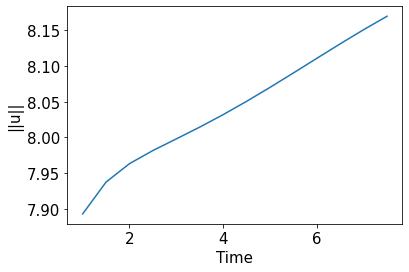

In [6]:
yew = np.zeros(len(qs))
vavg = np.zeros(len(qs))
for i in range(1,len(qs)):
    #print(t[i],np.linalg.norm(phi[i], ord = 2)/phiscale)
    vavg[i] = np.linalg.norm([x[i]-x[i-1],y[i]-y[i-1]])/delta_t/v0
    #print(t[i],"q",np.linalg.norm(qs[i])/qmax,"v",vavg)
    #print(t[i],np.linalg.norm(qs[i])/qmax/vavg)
    yew[i] = np.linalg.norm(qs[i])/qmax#/vavg
#plt.plot(t[:len(qs)],qs, lw = 3)
plt.plot(t[2:i+1], yew[2:])
plt.xlabel("Time")
plt.ylabel("||u||")
print(yew[1])
plt.savefig("ElecRatio.png", bbox_inches='tight')

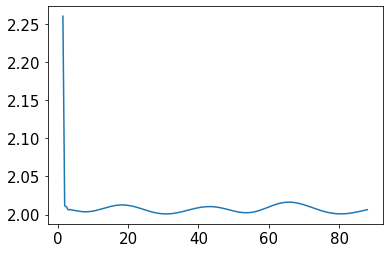

In [25]:
plt.plot(t[3:len(qs)],vavg[3:])

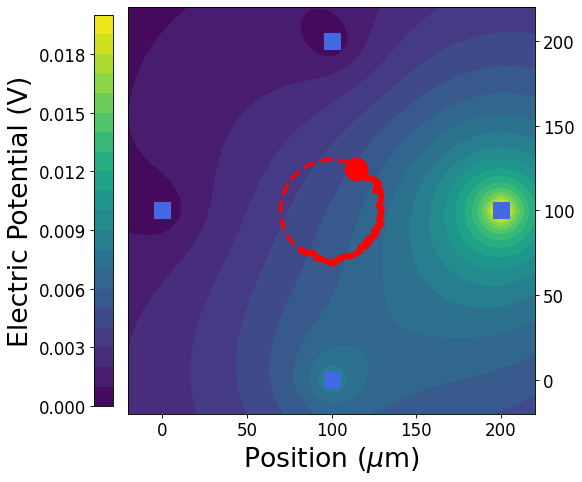

In [10]:
plt.rc("font",size = 15)
def plotit(xanswer,yanswer):
#     Vlo = -0.03
#     Vhi = 0.03
    margin = Lxy/10
    lower = 0-margin
    higher = Lxy+margin
    cm = 1E6 #this is to show the plot in micrometers (used to be centimeters)
    plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.clf()
    plt.contourf(X*cm,Y*cm,grid, levels = 21)#np.linspace(Vlo,Vhi,21), extend = "both")
    colorbar = plt.colorbar(shrink = 0.81, location = "left", pad = 0.03)
    colorbar.set_label("Electric Potential (V)", fontsize = 24)
    #plt.title("Electric Potential (V)", fontsize = 24)
#     targett = targetpos(t)
#     plt.plot(targett[0,:]*cm,targett[1,:]*cm, "r--", lw = 3)
    plt.plot(xanswer[k]*cm,yanswer[k]*cm, "o", color = "r", markersize = 20)
    ntail = 100
    if k< ntail:
        plt.plot(xanswer[:k+1]*cm,yanswer[:k+1]*cm,color = "r", linewidth = 5)
    else:
        plt.plot(xanswer[k-ntail:k]*cm,yanswer[k-ntail:k]*cm,color = "r", linewidth = 5)   
    plt.plot(chargepos[:,0]*cm, chargepos[:,1]*cm, "s", markersize = 15,  color = "royalblue")
    plt.xlabel("Position ($\mu$m)", fontsize = 24)   
#     plt.ylabel("Y Position ($\mu$m)", fontsize = 24)
    axes = plt.gca()
    axes.set_aspect('equal', adjustable='box')
    axes.add_patch(matplotlib.patches.Circle((xt*cm, yt*cm), rd*cm, linestyle = "--", color='r',fill=False, lw = 3))
    axes.set_xlim([lower*cm,higher*cm])
    axes.set_ylim([lower*cm,higher*cm])
    axes.yaxis.tick_right()
    #axes.get_xaxis().set_visible(False)
    #axes.get_yaxis().set_visible(False)
    time.sleep(1.0)
    clear_output(wait=True)
    display(plt.gcf())
    plt.savefig("End-electric.pdf", bbox_inches='tight')
    plt.close()
    return
plotit(x[:,:k],y[:,:k])

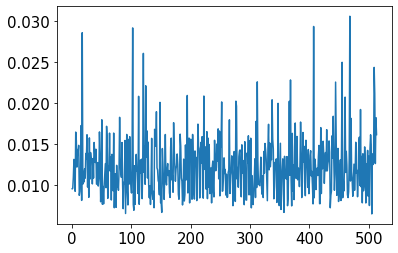

In [46]:
plt.plot(t[:k],timer0[:k])

In [11]:
print(min(grid[100]))

-0.0005268025782891429


In [10]:
print(X[100])

[0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002
 0.000

In [18]:
print((x[1]-x[0])/delta_t/v0,(y[1]-y[0])/delta_t/v0)

[1.94539893] [0.04244455]


In [33]:
D=epsilon0
D0 = epsilon0
feedbackgain=1.0
dt = delta_t
filename = "D="+str(D/D0)+"k="+str(feedbackgain)+"dt="+str(dt)
print(filename)

D=1.0k=1.0dt=0.5
